In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('data/20.xlsx')
df

,Unnamed: 0,ID,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,전용면적,건축년도,구별인구,거래량1,...,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수,위도,경도
0,0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,42166.7,4.162633,32.7,80,1987.0,557865,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.483372,127.053437
1,1,서울특별시 강남구 개포동 개포주공1단지 40,145736.8,10166.7,16.507998,7.0,40,1982.0,557865,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.483381,127.057068
2,2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,42678.6,0.000000,31.2,60,1983.0,557865,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,37.487868,127.068988
3,3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,45000.0,0.000000,25.4,80,1983.0,557865,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,37.487868,127.068988
4,4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,37909.1,9.134234,30.1,50,1983.0,557865,3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,37.488481,127.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,4294,서울특별시 중랑구 중화동 중화동건영아파트 60,25000.0,2500.0,6.000000,10.0,60,1998.0,411552,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.605430,127.082936
4087,4295,서울특별시 중랑구 중화동 태능에셈빌 80,35000.0,15000.0,0.000000,42.9,80,2005.0,411552,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.599447,127.078938
4088,4296,서울특별시 중랑구 중화동 한신아파트 50,31756.2,24571.4,0.000000,77.4,50,1997.0,411552,8,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,37.595961,127.080314
4089,4297,서울특별시 중랑구 중화동 한신아파트 60,36534.6,28111.1,2.996064,76.9,60,1997.1,411552,26,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,37.595961,127.080314


In [5]:
del df['Unnamed: 0']

In [6]:
df.dropna(inplace=True)
df

,ID,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,전용면적,건축년도,구별인구,거래량1,거래금액(만원)_18/2,...,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수,위도,경도
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,42678.6,0.000000,31.2,60,1983.0,557865,3,129500.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,37.487868,127.068988
3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,45000.0,0.000000,25.4,80,1983.0,557865,0,177416.7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,37.487868,127.068988
4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,37909.1,9.134234,30.1,50,1983.0,557865,3,128000.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,37.488481,127.072502
5,서울특별시 강남구 개포동 개포주공6단지 60,135200.0,43000.0,9.023669,31.8,60,1983.0,557865,2,131650.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,37.488481,127.072502
6,서울특별시 강남구 개포동 개포주공6단지 70,151500.0,50350.0,10.451045,33.2,70,1983.0,557865,2,150500.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,37.488481,127.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,서울특별시 중랑구 중화동 극동 80,36300.0,13000.0,13.223140,35.8,80,1991.0,411552,2,34125.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,37.604124,127.082326
4084,서울특별시 중랑구 중화동 동양엔파트 80,44000.0,37500.0,0.000000,85.2,80,2010.0,411552,4,45233.3,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,37.594222,127.075432
4088,서울특별시 중랑구 중화동 한신아파트 50,31756.2,24571.4,0.000000,77.4,50,1997.0,411552,8,32190.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,37.595961,127.080314
4089,서울특별시 중랑구 중화동 한신아파트 60,36534.6,28111.1,2.996064,76.9,60,1997.1,411552,26,38387.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,37.595961,127.080314


In [7]:
gongtong = df.iloc[:,145:174]
gongtong

,거래허가제TF,아파트TF,주상복합TF,도시형주택TF,일반분양TF,복합분양TF,임대분양TF,사용승인년도,동당세대수,세대수,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1983.0,156.666667,940.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1983.0,156.666667,940.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1983.0,117.777778,1060.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1983.0,117.777778,1060.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1983.0,117.777778,1060.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1991.0,156.000000,156.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
4084,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2010.0,51.500000,103.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0
4088,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1997.0,171.555556,1544.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0
4089,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1997.0,171.555556,1544.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0


In [8]:
df.iloc[:,1:9]

,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,전용면적,건축년도,구별인구,거래량1
2,136666.7,42678.6,0.000000,31.2,60,1983.0,557865,3
3,177416.7,45000.0,0.000000,25.4,80,1983.0,557865,0
4,125900.0,37909.1,9.134234,30.1,50,1983.0,557865,3
5,135200.0,43000.0,9.023669,31.8,60,1983.0,557865,2
6,151500.0,50350.0,10.451045,33.2,70,1983.0,557865,2
...,...,...,...,...,...,...,...,...
4083,36300.0,13000.0,13.223140,35.8,80,1991.0,411552,2
4084,44000.0,37500.0,0.000000,85.2,80,2010.0,411552,4
4088,31756.2,24571.4,0.000000,77.4,50,1997.0,411552,8
4089,36534.6,28111.1,2.996064,76.9,60,1997.1,411552,26


In [9]:
dic = {}
num = 1

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num:num+8]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],gongtong], axis=1)
    num += 8

dic['data1']

,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,전용면적,건축년도,구별인구,거래량1,거래허가제TF,아파트TF,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
2,136666.7,42678.6,0.000000,31.2,60,1983.0,557865,3,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,177416.7,45000.0,0.000000,25.4,80,1983.0,557865,0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,125900.0,37909.1,9.134234,30.1,50,1983.0,557865,3,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
5,135200.0,43000.0,9.023669,31.8,60,1983.0,557865,2,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
6,151500.0,50350.0,10.451045,33.2,70,1983.0,557865,2,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,36300.0,13000.0,13.223140,35.8,80,1991.0,411552,2,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
4084,44000.0,37500.0,0.000000,85.2,80,2010.0,411552,4,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0
4088,31756.2,24571.4,0.000000,77.4,50,1997.0,411552,8,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0
4089,36534.6,28111.1,2.996064,76.9,60,1997.1,411552,26,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0


In [10]:
dic['data18']

,거래금액(만원)_22/2,전세금(만원)_22/2,등락율,전세가율,전용면적.17,건축년도.17,구별인구.17,거래량18,거래허가제TF,아파트TF,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
2,202800.0,44265.0,0.0,21.8,60,1983.0,536710,0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,282250.0,62400.0,0.0,22.1,80,1983.0,536710,0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,189000.0,43116.7,0.0,22.8,50,1983.0,536710,0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
5,181000.0,39239.8,0.0,21.7,60,1983.0,536710,0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
6,270000.0,57225.0,0.0,21.2,70,1983.0,536710,0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,56933.3,47500.0,0.0,83.4,80,1991.0,393147,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
4084,78800.0,35000.0,0.0,44.4,80,2010.0,393147,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0
4088,70000.0,37000.0,0.0,52.9,50,1997.0,393147,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0
4089,73000.0,36116.8,0.0,49.5,60,1997.1,393147,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0


In [11]:
dic['data1'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3225 entries, 2 to 4090
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   거래금액(만원)_18/1  3225 non-null   float64
 1   전세금(만원)_18/1   3225 non-null   float64
 2   등락율18/1        3225 non-null   float64
 3   전세가율18/1       3225 non-null   float64
 4   전용면적           3225 non-null   int64  
 5   건축년도           3225 non-null   float64
 6   구별인구           3225 non-null   int64  
 7   거래량1           3225 non-null   int64  
 8   거래허가제TF        3225 non-null   float64
 9   아파트TF          3225 non-null   float64
 10  주상복합TF         3225 non-null   float64
 11  도시형주택TF        3225 non-null   float64
 12  일반분양TF         3225 non-null   float64
 13  복합분양TF         3225 non-null   float64
 14  임대분양TF         3225 non-null   float64
 15  사용승인년도         3225 non-null   float64
 16  동당세대수          3225 non-null   float64
 17  세대수            3225 non-null   float64
 18  관리원당세대수 

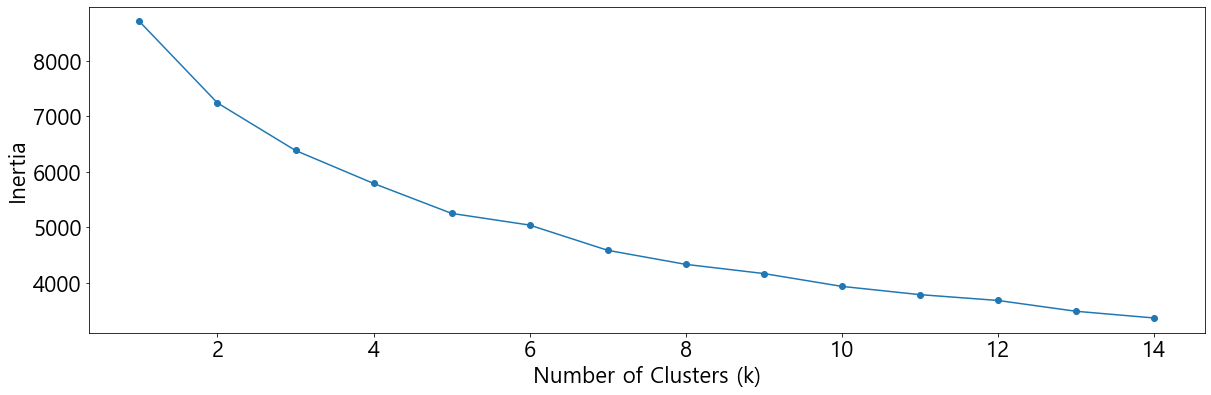

In [12]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

num_clusters = list(range(1, 15))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [13]:
# 스케일링과 클러스터링
mm = MinMaxScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=11, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [14]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,전용면적,건축년도,구별인구,거래량1,거래허가제TF,아파트TF,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
cluster,,,,,,,,,,,,,,,,,,,,,
0,283,283,283,283,283,283,283,283,283,283,...,283,283,283,283,283,283,283,283,283,283
1,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
2,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
3,437,437,437,437,437,437,437,437,437,437,...,437,437,437,437,437,437,437,437,437,437
4,501,501,501,501,501,501,501,501,501,501,...,501,501,501,501,501,501,501,501,501,501
5,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
6,287,287,287,287,287,287,287,287,287,287,...,287,287,287,287,287,287,287,287,287,287
7,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
8,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188


In [15]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,전세금(만원)_20/1,등락율.9,전세가율.9,전용면적.8,건축년도.8,구별인구.8,거래량9,거래허가제TF,아파트TF,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
cluster,,,,,,,,,,,,,,,,,,,,,
0,284,284,284,284,284,284,284,284,284,284,...,284,284,284,284,284,284,284,284,284,284
1,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
2,402,402,402,402,402,402,402,402,402,402,...,402,402,402,402,402,402,402,402,402,402
3,437,437,437,437,437,437,437,437,437,437,...,437,437,437,437,437,437,437,437,437,437
4,501,501,501,501,501,501,501,501,501,501,...,501,501,501,501,501,501,501,501,501,501
5,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
6,287,287,287,287,287,287,287,287,287,287,...,287,287,287,287,287,287,287,287,287,287
7,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
8,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188


In [16]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,전세금(만원)_22/2,등락율,전세가율,전용면적.17,건축년도.17,구별인구.17,거래량18,거래허가제TF,아파트TF,...,중앙난방TF,지역난방TF,복도식TF,혼합형TF,계단식TF,메이저시공사TF,조합시행TF,철근철골구조TF,홈네트워크TF,관리시설수
cluster,,,,,,,,,,,,,,,,,,,,,
0,284,284,284,284,284,284,284,284,284,284,...,284,284,284,284,284,284,284,284,284,284
1,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
2,402,402,402,402,402,402,402,402,402,402,...,402,402,402,402,402,402,402,402,402,402
3,437,437,437,437,437,437,437,437,437,437,...,437,437,437,437,437,437,437,437,437,437
4,501,501,501,501,501,501,501,501,501,501,...,501,501,501,501,501,501,501,501,501,501
5,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
6,287,287,287,287,287,287,287,287,287,287,...,287,287,287,287,287,287,287,287,287,287
7,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
8,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188
